In [0]:
!python --version

Python 3.6.9


In [0]:
#!nvidia-smi

In [0]:
# Importing Standard Python Libraries
ls = ['math','os','sys','datetime','shutil']
for i in ls:
    exec('import {0}'.format(i))
    exec('print("imported {0}")'.format(i))

imported math
imported os
imported sys
imported datetime
imported shutil


In [0]:
# Using GDrive storage as file-system for experimentation
from google.colab import drive
try:
    drive.mount('/content/gdrive')
    os.chdir('gdrive/My Drive/CNN_project')
except:
    pass

# Removing Permission if you want to unmount
# https://myaccount.google.com/permissions

os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


'/content/gdrive/My Drive/CNN_project'

In [0]:
os.listdir()

['data1.h5',
 'datasets',
 'data_extract.ipynb',
 'x_vgg_train.csv',
 'x_vgg_test.csv',
 'PartB.ipynb',
 'PartA.ipynb']

In [0]:
# !unzip "/content/gdrive/My Drive/CNN_project/data.h5.zip" -d "./"

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Importing Standard Data Science & Plotting libraries
import numpy as np, pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [0]:
# Importing Deep Learning Libraries
ls = ['tensorflow','h5py','sklearn']

for i in ls:
    exec('import {0}'.format(i))
    exec('print("Version of {0}",{0}.__version__)'.format(i))

Version of tensorflow 2.2.0-rc3
Version of h5py 2.10.0
Version of sklearn 0.22.2.post1


In [0]:
# Function to load data from extracted file
def loadDataH5():
    with h5py.File('data1.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [0]:
trainX, trainY, testX, testY = loadDataH5()

(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)


In [0]:
set(trainY), set(testY)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})

In [0]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = (trainX, trainY), (testX, testY)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
y_train.shape, y_test.shape

x_train shape: (1020, 128, 128, 3)
1020 train samples
340 test samples


((1020,), (340,))

In [0]:
%%time
# Function to extract features from VGG16 pre-trained architecture
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(x_train.shape[1:]), pooling='max')


def vgg_features(data, model):
    data = np.clip(np.round(255*data),0,255)
    data = preprocess_input(data)
    features = model.predict(data)
    return np.array(features)

58892288/58889256 [==============================] - 0s 0us/step
CPU times: user 789 ms, sys: 428 ms, total: 1.22 s
Wall time: 8.18 s


In [0]:
if 'x_vgg_train.csv' not in os.listdir():
    x_vgg_train = vgg_features(x_train, vgg_model)
    x_vgg_test  = vgg_features(x_test , vgg_model)
    df_x_vgg_train, df_x_vgg_test = pd.DataFrame(x_vgg_train), pd.DataFrame(x_vgg_test)
    df_x_vgg_train.to_csv('x_vgg_train.csv', header=False, index=False)
    df_x_vgg_test.to_csv( 'x_vgg_test.csv' , header=False, index=False)
else:
    x_vgg_train, x_vgg_test = pd.read_csv('x_vgg_train.csv',header=None), pd.read_csv('x_vgg_test.csv',header=None)
x_vgg_train.shape, x_vgg_test.shape

((1020, 512), (340, 512))

In [0]:
from sklearn.naive_bayes           import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.svm                   import SVC
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neural_network        import MLPClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [0]:
class ML_model:
    "Class for Secondary Machine learning algorithms with common function interface to Scikit"
    def __init__(self, name, params):
        self.name = name
        self.params = params
        if self.name=='GNB':
            self.model = GaussianNB()
        if self.name=='LDA':
            self.model = LinearDiscriminantAnalysis()
        if self.name=='KNN':
            self.model = KNeighborsClassifier()
        if self.name=='LR':
            self.model = LogisticRegression()
        if self.name=='SVM':
            self.model = SVC()
        if self.name=='RF':
            self.model = RandomForestClassifier()
        if self.name=='NN':
            self.model = MLPClassifier()

    def fit(self, x_data, y_data, cv=5):
        "Grid search for givem Secondary ML algorithm"
        self.grid_clf = GridSearchCV(self.model, self.params, cv=cv)
        self.grid_clf.fit(x_data, y_data)

    def score(self, x, y):
        return self.grid_clf.score(x,y)

    def predict(self, x, y):
        return self.grid_clf.predict(x,y)

    def predict_proba(self, x, y):
        return self.grid_clf.predict_proba(x,y)

In [0]:
%%time
clf = ML_model('GNB', {'priors':[None]})
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'priors': None}
Best Accuracy on Validation set using Grid Search is 62.94%
CPU times: user 131 ms, sys: 9.35 ms, total: 141 ms
Wall time: 140 ms


In [0]:
%%time
clf = ML_model('LDA', {'solver':['svd','lsqr','eigen']})
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'solver': 'svd'}
Best Accuracy on Validation set using Grid Search is 78.82%
CPU times: user 6.36 s, sys: 6.97 s, total: 13.3 s
Wall time: 3.41 s


In [0]:
%%time
clf = ML_model('KNN', {
    'n_neighbors':[1,3,5,7,9,15,31,61,120],
    'p':[1,2]
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'n_neighbors': 5, 'p': 2}
Best Accuracy on Validation set using Grid Search is 79.41%
CPU times: user 19.3 s, sys: 0 ns, total: 19.3 s
Wall time: 19.3 s


In [0]:
%%time
clf = ML_model('LR', {
    'penalty':['l1','l2'],
    'C':[0.001,0.1,1,10,100]
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'C': 0.1, 'penalty': 'l2'}
Best Accuracy on Validation set using Grid Search is 89.41%
CPU times: user 20.7 s, sys: 20.2 s, total: 41 s
Wall time: 10.3 s


In [0]:
%%time
clf = ML_model('SVM', {
    'kernel':['linear','poly','rbf'],
    'C':[0.001,0.1,1,10,100]
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'C': 10, 'kernel': 'rbf'}
Best Accuracy on Validation set using Grid Search is 89.71%
CPU times: user 58.4 s, sys: 0 ns, total: 58.4 s
Wall time: 58.4 s


In [0]:
%%time
clf = ML_model('RF', {
    'max_depth':[4,8,16],
    'min_samples_split':[4,8,16],
    'min_samples_leaf':[2,4,8],
    'max_features':[8,16,32],
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'max_depth': 16, 'max_features': 32, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best Accuracy on Validation set using Grid Search is 83.24%
CPU times: user 3min 36s, sys: 304 ms, total: 3min 36s
Wall time: 3min 36s


In [0]:
%%time
clf = ML_model('NN', {
    'hidden_layer_sizes':[(64, ),(128, ),(256, ),(512, )],
    'activation':['relu','tanh'],
    'alpha':[0.0,0.01,0.001],
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'activation': 'tanh', 'alpha': 0.0, 'hidden_layer_sizes': (512,)}
Best Accuracy on Validation set using Grid Search is 86.47%
CPU times: user 13min, sys: 11min 41s, total: 24min 42s
Wall time: 6min 12s


In [0]:
%%time
clf = ML_model('NN', {
    'hidden_layer_sizes':[(512,256 ),(512,128 ),(512,64 ),(512,28 )],
    'activation':['relu','tanh'],
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'activation': 'tanh', 'hidden_layer_sizes': (512, 256)}
Best Accuracy on Validation set using Grid Search is 86.76%
CPU times: user 10min 44s, sys: 9min 14s, total: 19min 59s
Wall time: 5min 7s


In [0]:
%%time
clf = ML_model('NN', {
    'hidden_layer_sizes':[(2048,1024,512,256 ),],
    'activation':['relu','tanh'],
    })
clf.fit(x_vgg_train,y_train)
print(clf.grid_clf.best_params_)
print('Best Accuracy on Validation set using Grid Search is {0:.2f}%'.format(100*clf.score(x_vgg_test,y_test)))

{'activation': 'tanh', 'hidden_layer_sizes': (2048, 1024, 512, 256)}
Best Accuracy on Validation set using Grid Search is 88.53%
CPU times: user 13min 33s, sys: 9min 39s, total: 23min 13s
Wall time: 5min 50s


In [0]:
%%time
"Stacking ensemble for all best Secondary ML algorithms"
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(estimators=[
                                           ('GNB',GaussianNB(priors=None)),
                                           ('LDA',LinearDiscriminantAnalysis(solver='svd')),
                                           ('KNN',KNeighborsClassifier(n_neighbors=5,p=2)),
                                           ('LR' ,LogisticRegression(penalty='l2',C=0.1)),
                                           ('SVM',SVC(kernel='rbf',C=10)),
                                           ('RF' ,RandomForestClassifier(max_depth=16,max_features=32, min_samples_leaf=2, min_samples_split=8)),
                                           ('NN' ,MLPClassifier(activation='tanh', hidden_layer_sizes=(2048,1024,512,256)))
                                           ],
                               final_estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(128,64)),
                               passthrough=True,
                               )
stack_clf.fit(x_vgg_train, y_train)
print('Best Accuracy on Validation set using Stacking Classifier is {0:.2f}%'.format(100*stack_clf.score(x_vgg_test,y_test)))

Best Accuracy on Validation set using Stacking Classifier is 83.24%
CPU times: user 7min 19s, sys: 5min 27s, total: 12min 46s
Wall time: 3min 23s


In [0]:
%%time
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input_19

num_classes = 17

class VGG_CNN:
    "Class for creating VGG-19 based transfer learning model"

    def __init__(self, num_classes, input_shape, model_choice=0):
        self.num_classes = num_classes
        self.vgg_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        # Freexing all layers of VGG-19 to be untrainable
        self.vgg_model.trainable = False
        for layer in self.vgg_model.layers:
            layer = True

        if model_choice==0:
            "Fully connected head model on top of pre-trained VGG-19 with Dropout"
            IP = self.vgg_model.output
            X = Flatten()(IP)
            X = Dense(2048)(X)
            X = BatchNormalization()(X)
            X = Activation('tanh')(X)
            X = Dropout(0.25)(X)
            X = Dense(1024)(X)
            X = BatchNormalization()(X)
            X = Activation('tanh')(X)
            X = Dropout(0.25)(X)
            X = Dense(512)(X)
            X = BatchNormalization()(X)
            X = Activation('tanh')(X)
            X = Dropout(0.25)(X)
            X = Dense(256)(X)
            X = BatchNormalization()(X)
            X = Activation('tanh')(X)
            X = Dropout(0.25)(X)
            X = Dense(self.num_classes)(X)
            OP = Activation('softmax')(X)
            self.model = Model(inputs=self.vgg_model.input, outputs=OP)

    def train(self, train, test, batch_size=64, epochs=300, opt='Adam', lr=0.01, data_augmentation=False, verbose=1, unfreeze=0):
        self.vgg_model.trainable = False
        # Opening the last few layers of VGG-19 base for fine tuning
        for ix in range(1, unfreeze+1):
            self.vgg_model.layers[-1*ix].trainable = True
        (x_train, y_train), (x_test, y_test) = train, test
        x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
        x_train, x_test = np.clip(255*x_train,0,255), np.clip(255*x_test,0,255)
        # preprocessing image data as per VGG-19 images are preprocessed
        x_train, x_test = preprocess_input(x_train), preprocess_input(x_test)
        # Selcting optimizer and compiling model
        opt = eval('tensorflow.keras.optimizers.{}(learning_rate={})'.format(opt, lr))
        self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])
        # Training data with or without data augmentation, depending upon user input
        if not data_augmentation:
            history = self.model.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epochs,
                                     validation_data=(x_test, y_test),
                                     shuffle=True,
                                     callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True),
                                                ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=10, min_delta=0.0001, min_lr=0.0001, verbose=1)],
                                                verbose=verbose)
        else:
            datagen = ImageDataGenerator(
            rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.25,  # set range for random shear
            zoom_range=0.5,  # set range for random zoom
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True,  # randomly flip images
            )

            datagen.fit(x_train)
            # Fit the model on the batches generated by datagen.flow().
            history = self.model.fit(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                                     epochs=epochs,
                                     steps_per_epoch = len(x_train)//batch_size,
                                     validation_data=(x_test, y_test),
                                     callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True),
                                                ReduceLROnPlateau(monitor='loss', factor=1/3, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)],
                                     verbose=verbose,
                                     workers=4)
        self.history = history.history

    def evaluate(self,x_test, y_test):
        x_test = np.clip(255*x_test,0,255)
        x_test = preprocess_input(x_test)
        scores = self.model.evaluate(x_test, y_test, verbose=1)
        print('Evaluated loss:'     , scores[0])
        print('Evaluated accuracy:' , scores[1])

    def predict(self,x_test):
        x_test = np.clip(255*x_test,0,255)
        x_test = preprocess_input(x_test)
        return self.model.predict(x_test, verbose=1)

    def plot(self, metric='loss'):
        for key in self.history:
            if metric in key:
                plt.plot(self.history[key],label=key)
        plt.legend()
        plt.grid(True, which='both')
        plt.xlabel('Number of Epochs')
        plt.ylabel('{} value'.format(metric))
        plt.title('Training progress of {}'.format(metric))
        plt.show()

CPU times: user 81 µs, sys: 5 µs, total: 86 µs
Wall time: 95.6 µs



Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0003333333491658171.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00011111111962236464.
11/11 [==============================] - 1s 106ms/step - loss: 0.3124 - accuracy: 0.9206
Evaluated loss: 0.3123951852321625
Evaluated accuracy: 0.9205882549285889


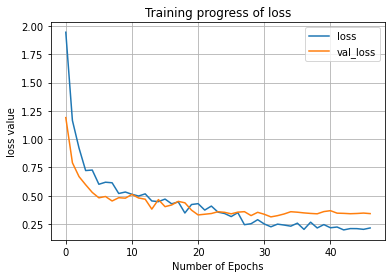

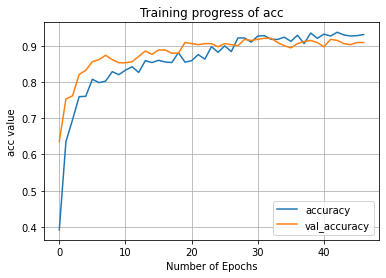

CPU times: user 4min 31s, sys: 9.7 s, total: 4min 40s
Wall time: 3min 55s


In [0]:
%%time
model = VGG_CNN(num_classes, x_train.shape[1:], model_choice=0)
model.train( (x_train,y_train), (x_test,y_test), batch_size=64, epochs=300, opt='Adam', lr=0.001, data_augmentation=True, verbose=0)
model.evaluate(x_test, y_test)
model.plot('loss') ; model.plot('acc')


Epoch 00034: ReduceLROnPlateau reducing learning rate to 3.33333324912625e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.1111111234640703e-05.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 3.703703744880234e-06.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.2345678896963364e-06.
11/11 [==============================] - 1s 106ms/step - loss: 0.1149 - accuracy: 0.9588
Evaluated loss: 0.11486999690532684
Evaluated accuracy: 0.9588235020637512


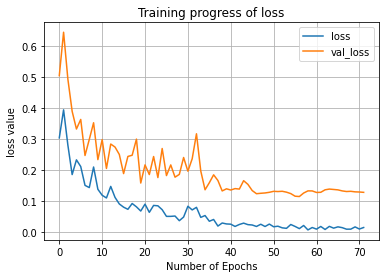

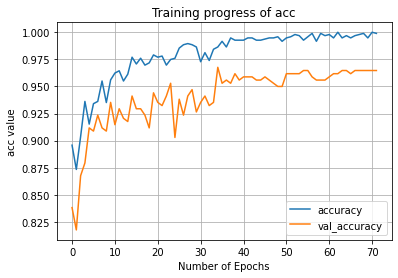

CPU times: user 6min 57s, sys: 30.2 s, total: 7min 27s
Wall time: 6min 34s


In [0]:
%%time
model.train( (x_train,y_train), (x_test,y_test), batch_size=64, epochs=300, opt='Adam', lr=0.0001, data_augmentation=True, verbose=0, unfreeze=5)
model.evaluate(x_test, y_test)
model.plot('loss') ; model.plot('acc')


Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000353708551e-06.
11/11 [==============================] - 1s 106ms/step - loss: 0.1103 - accuracy: 0.9647
Evaluated loss: 0.11029797047376633
Evaluated accuracy: 0.9647058844566345


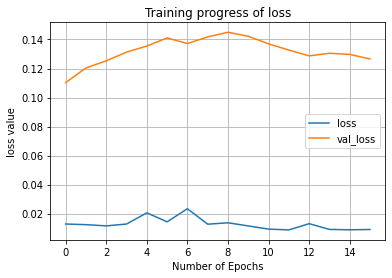

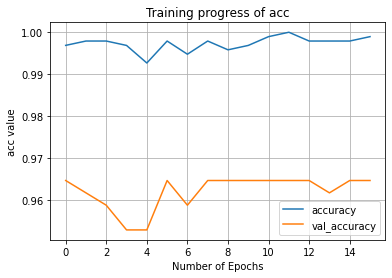

CPU times: user 1min 48s, sys: 15.3 s, total: 2min 3s
Wall time: 1min 52s


In [0]:
%%time
model.train( (x_train,y_train), (x_test,y_test), batch_size=64, epochs=300, opt='Adam', lr=0.000003, data_augmentation=True, verbose=0, unfreeze=10)
model.evaluate(x_test, y_test)
model.plot('loss') ; model.plot('acc')